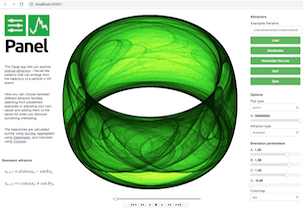

## Panel/Numba/Datashader Strange Attractors app

[Strange attractors](attractors.ipynb) are a type of iterative equation that traces the path of a particle through a 2D space, forming interesting patterns in the trajectories. 

There are many attractor families determined by a set of attractor equations, each with associated numerical parameters. To make the parameter space easy to explore, we'll build an app that selects between the attractor families and allows you to manipulate their parameter values. Using this app requires `conda install -c pyviz/label/dev panel param datashader` and a live, running Python process (not just a static web page or anaconda.org viewer). You may wish to check out the much simpler [Clifford-only app](clifford_panel.ipynb) first, to understand the basic structure of an app and of how to compute an attractor.

## Attractor definitions

First, we'll define a function for collecting the values of any attractor function with up to six parameters, using [Numba](http://numba.pydata.org) to make it 50X faster than bare [Python](http://python.org):

In [1]:
import numpy as np, pandas as pd
from numba import jit

@jit(nopython=True)
def trajectory_coords(fn, x0, y0, a, b, c, d, e, f, n):
    x, y = np.zeros(n), np.zeros(n)
    x[0], y[0] = x0, y0
    for i in np.arange(n-1):
        x[i+1], y[i+1] = fn(x[i], y[i], a, b, c, d, e, f)
    return x, y

def trajectory(fn, x0, y0, a, b=None, c=None, d=None, e=None, f=None, n=1000000):
    xs, ys = trajectory_coords(fn, x0, y0, a, b, c, d, e, f, n)
    return pd.DataFrame(dict(x=xs,y=ys))

Next, we'll define a class hierarchy to provide a shared interface for the various attractor types:

In [2]:
import param, panel as pn, inspect
pn.extension('katex')

class Attractor(param.Parameterized):
    """A parameterized object that can evaluate an attractor trajectory"""
    
    x = param.Number(0,  softbounds=(-2, 2), doc="Starting x value", precedence=-1)
    y = param.Number(0,  softbounds=(-2, 2), doc="Starting y value", precedence=-1)

    a = param.Number(1.7, bounds=(-3, 3), doc="Attractor parameter a")
    b = param.Number(1.7, bounds=(-3, 3), doc="Attractor parameter b")

    colormap = param.ObjectSelector("kgy", precedence=0.7, check_on_set=False,
        objects=['bgy', 'bmw', 'bgyw', 'bmy', 'fire', 'gray', 'kgy', 'kbc', 'viridis', 'inferno'])

    equations = param.List([], class_=str, precedence=-1, readonly=True)
    
    __abstract = True
    
    def __call__(self, n, x=None, y=None):
        """Return a dataframe with *n* points"""
        if x is not None: self.x=x
        if y is not None: self.y=y
        args = [getattr(self,p) for p in self.sig()]
        return trajectory(self.fn, *args, n=n)
    
    def vals(self):
        return [self.__class__.name] + [self.colormap] + [getattr(self,p) for p in self.sig()]

    def sig(self):
        """Returns the calling signature expected by this attractor function"""
        return list(inspect.signature(self.fn).parameters.keys())[:-1]
    
class FourParamAttractor(Attractor):
    """Base class for most four-parameter attractors"""
    c = param.Number(0.6, softbounds=(-3, 3), doc="Attractor parameter c")
    d = param.Number(1.2, softbounds=(-3, 3), doc="Attractor parameter d")

    __abstract = True

Each type of attractor is then a subclass in this hierarchy, capturing the attractor equations (both in LaTeX form for printing and as a runnable Python function), their parameters, and their expected ranges of values:

In [3]:
from numpy import sin, cos, sqrt, fabs

class Clifford(FourParamAttractor):
    equations = param.List([r'$x_{n+1} = \sin\ ay_n + c\ \cos\ ax_n$', 
                            r'$y_{n+1} = \sin\ bx_n + d\ \cos\ by_n$'])
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, d, *o):
        return sin(a * y) + c * cos(a * x), \
               sin(b * x) + d * cos(b * y)


class De_Jong(FourParamAttractor):
    equations = param.List([r'$x_{n+1} = \sin\ ay_n - c\ \cos\ bx_n$', 
                            r'$y_{n+1} = \sin\ cx_n - d\ \cos\ dy_n$'])
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, d, *o):
        return sin(a * y) - cos(b * x), \
               sin(c * x) - cos(d * y)

    
class Svensson(FourParamAttractor):
    equations = param.List([r'$x_{n+1} = d\ \sin\ ax_n - \sin\ by_n$', 
                            r'$y_{n+1} = c\ \cos\ ax_n + \cos\ by_n$'])
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, d, *o):
        return d * sin(a * x) - sin(b * y), \
               c * cos(a * x) + cos(b * y)

    
class Fractal_Dream(Attractor):
    equations = param.List([r'$x_{n+1} = \sin\ by_n + c\ \sin\ bx_n$', 
                            r'$y_{n+1} = \sin\ ax_n + d\ \sin\ ay_n$'])
    
    c = param.Number(1.15, softbounds=(-0.5, 1.5), doc="Attractor parameter c")
    d = param.Number(2.34, softbounds=(-0.5, 1.5), doc="Attractor parameter d")
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, d, *o):
        return sin(b*y)+c*sin(b*x), \
               sin(a*x)+d*sin(a*y)

    
class Bedhead(Attractor):
    equations = param.List([r'$x_{n+1} = y_n\ \sin\ \frac{x_ny_n}{b} + \cos(ax_n-y_n)$', 
                            r'$y_{n+1} = x_n+\frac{\sin\ y_n}{b}$'])
    
    a = param.Number(0.64, bounds=(-1, 1))
    b = param.Number(0.76, bounds=(-1, 1))
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, *o):
        return y*sin(x*y/b) + cos(a*x-y), \
               x + sin(y)/b
    
    def __call__(self, n):
        # Avoid interactive divide-by-zero errors for b
        epsilon = 3*np.finfo(float).eps
        if -epsilon < self.b < epsilon:
            self.b = epsilon
        return super(Bedhead,self).__call__(n)

    
class Hopalong1(Attractor):
    equations = param.List([r'$x_{n+1} = y_n-\mathrm{sgn}(x_n)\sqrt{\left|\ bx_n-c\ \right|}$', 
                            r'$y_{n+1} = a-x_n$'])
    
    a = param.Number(9.8, bounds=(0, 10))
    b = param.Number(4.1, bounds=(0, 10))
    c = param.Number(3.8, bounds=(0, 10), doc="Attractor parameter c")

    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, *o):
        return y - sqrt(fabs(b * x - c)) * np.sign(x), \
               a - x


class Hopalong2(Hopalong1):
    equations = param.List([r'$x_{n+1} = y_n-1-\mathrm{sgn}(x_n-1)\sqrt{\left|\ bx_n-1-c\ \right|}$', 
                            r'$y_{n+1} = a-x_n-1$'])
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, c, *o):
        return y - 1.0 - sqrt(fabs(b * x - 1.0 - c)) * np.sign(x - 1.0), \
               a - x - 1.0


@jit(nopython=True)
def G(x, mu):
    return mu * x + 2 * (1 - mu) * x**2 / (1.0 + x**2)

class Gumowski_Mira(Attractor):
    equations = param.List([r'$G(x) = \mu x + \frac{2(1-\mu)x^2}{1+x^2}$',
                            r'$x_{n+1} = y_n + ay_n(1-by_n^2) + G(x_n)$', 
                            r'$y_{n+1} = -x_n + G(x_{n+1})$'])
    
    x = param.Number(0,    softbounds=(-20, 20), doc="Starting x value", precedence=0.1)
    y = param.Number(0,    softbounds=(-20, 20), doc="Starting y value", precedence=0.1)
    a = param.Number(0.64, softbounds=( -1,  1))
    b = param.Number(0.76, softbounds=( -1,  1))
    mu = param.Number(0.6, softbounds=( -2,  2), doc="Attractor parameter mu")
    
    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, mu, *o):
        xn = y + a*(1 - b*y**2)*y  +  G(x, mu)
        yn = -x + G(xn, mu)
        return xn, yn


class Symmetric_Icon(Attractor):
    a = param.Number(0.6, softbounds=(-20, 20),  bounds=(None,None), doc="Attractor parameter alpha")
    b = param.Number(1.2, softbounds=(-20, 20),  bounds=(None,None), doc="Attractor parameter beta")
    g = param.Number(0.6, softbounds=(-1,   1),  bounds=(None,None), doc="Attractor parameter gamma")
    om= param.Number(1.2, softbounds=(-0.2, 0.2),bounds=(None,None), doc="Attractor parameter omega")
    l = param.Number(0.6, softbounds=(-3,   3),  bounds=(None,None), doc="Attractor parameter lambda")
    d = param.Number(1.2, softbounds=( 1,  20),  bounds=(None,None), doc="Attractor parameter degree")

    @staticmethod
    @jit(nopython=True)
    def fn(x, y, a, b, g, om, l, d, *o):
        zzbar = x*x + y*y
        p = a*zzbar + l
        zreal, zimag = x, y
    
        for i in range(1, d-1):
            za, zb = zreal * x - zimag * y, zimag * x + zreal * y
            zreal, zimag = za, zb
    
        zn = x*zreal - y*zimag
        p += b*zn
    
        return p*x + g*zreal - om*y, \
               p*y - g*zimag + om*x

Using these attractor objects, we can look at the equations for them:

In [4]:
from IPython.core.display import display, HTML, Latex
display(HTML("<style>.container { width:100% !important; }</style>"))

display(*[Latex(e) for e in Gumowski_Mira.equations])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

And we can run them for specified parameter values to calculate `n` (x,y) positions of the simulated particle through space:

In [5]:
trajectory(Hopalong1.fn, 0, 0, a=1, b=3, c=5, n=5)

,x,y
0,0.000000,0.000000
1,0.000000,1.000000
2,1.000000,1.000000
3,-0.414214,0.000000
4,2.498528,1.414214


## Attractor parameter values

Many of these attractors have only specific sets of parameters that are visually striking.  Suitable parameters have been collected into a separate [YAML-format text file](https://raw.githubusercontent.com/pyviz-topics/examples/master/attractors/attractors.yml), which we can load here, add new values to, save, etc.:

In [6]:
import numpy.random as npr, yaml
npr.seed(12)

class ParameterSets(param.Parameterized):
    """
    Allows selection from sets of pre-defined parameters saved in YAML.
    
    Assumes the YAML file returns a list of groups of values.
    """

    examples_filename = param.Filename("attractors.yml")
    remember_this_one = param.Action(lambda x: x._remember())
    
    load      = param.Action(lambda x: x._load())
    randomize = param.Action(lambda x: x._randomize())
    sort      = param.Action(lambda x: x._sort())
    save      = param.Action(lambda x: x._save(), precedence=0.8)
    example   = param.Integer(0, bounds=(0,None), softbounds=(0,100),
                              precedence=-1,
                              doc="Index of current set of values")

    def __init__(self,**params):
        super(ParameterSets,self).__init__(**params)
        self._load()

    def _load(self):
        with open(self.examples_filename,"r") as f: 
            self.valslist = yaml.safe_load(f)

    def _save(self):
        with open(self.examples_filename,"w") as f: 
            yaml.dump(self.valslist,f)

    def __call__(self):        return self.valslist[self.example%len(self.valslist)]
    def _randomize(self):      npr.shuffle(self.valslist)
    def _sort(self):           self.valslist = list(sorted(self.valslist))
    def _add_item(self, item): self.valslist += item ; self.example=len(self.valslist)-1
    def _remember(self):
        vals = ats.attractor_type.vals() # forward reference
        self._add_item([vals])
        
    def args(self, name):
        return [v[1:] for v in self.valslist if v[0]==name]


params = ParameterSets(name="Attractors")
#pn.Row(params)

We can now define an example of each attractor family and allow users to select between them or create a new one of a given type:

In [7]:
from param import concrete_descendents
from collections import OrderedDict
attractors = OrderedDict(sorted([(k,v(name=k + " parameters")) for k,v in concrete_descendents(Attractor).items()]))

def attractor_obj(name, *args):
    """Factory function to return an Attractor object with the given name and arg values"""
    attractor = attractors[name]
    fn_params = ['colormap'] + attractor.sig()
    attractor.param.set_param(**dict(zip(fn_params, args)))
    return attractor

#attractor_obj('Gumowski_Mira', None, 0.1, 0.1, 0.0, 0.5, -0.75)

In [8]:
for k in attractors:
    attractor_obj(k, *params.args(k)[0])

#pn.Row(attractors["Clifford"], attractors["Svensson"])

## Attractor plotting using Datashader

To turn the attractors into visible images, we'll define some plotting code using [Datashader](http://datashader.org):

In [9]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import inferno, viridis
from colorcet import palette
palette["viridis"]=viridis
palette["inferno"]=inferno

size=700

def datashade(df, plot_type='points', cmap=palette["inferno"]):
    cvs = ds.Canvas(plot_width=size, plot_height=size)
    agg = getattr(cvs,plot_type)(df, 'x', 'y', agg=ds.count())
    return tf.shade(agg, cmap=cmap)

#datashade(trajectory(Hopalong1.fn, 0, 0, a=1, b=3, c=5, n=5000000))

# Panel dashboard

We could use `datashade` on its own to plot any of these attractors, or `IPython.display.Latex` to render the equations mathematically. But to make it much simple to explore, let's build an app with widgets using Panel. We'll first make an object that lets us select between attractor families, types of plots, etc.:

In [10]:
from panel import Column
from panel.pane import LaTeX

class Attractors(param.Parameterized):
    attractor_type = param.ObjectSelector(attractors["Clifford"], attractors,
                                          precedence=0.9)

    parameters = param.ObjectSelector(params, precedence=-0.5, readonly=True)

    plot_type = param.ObjectSelector("points", precedence=0.8, 
        objects=['points', 'line'], doc="Type of aggregation to use")

    n = param.Integer(2000000, bounds=(1,None), softbounds=(1,50000000),
                      doc="Number of points", precedence=0.85)
    
    @param.depends("parameters.param", watch=True)
    def _update_from_parameters(self):
        a = attractor_obj(*self.parameters())
        if a is not self.attractor_type:
            self.set_param(attractor_type=a)
        
    @param.depends("attractor_type.param", "plot_type", "n")
    def view(self):
        return datashade(self.attractor_type(n=self.n), self.plot_type, 
                         palette[self.attractor_type.colormap][::-1])

    @param.depends("attractor_type")
    def equations(self):
        if not self.attractor_type.equations:
            return Column()
        return Column("<b>"+self.attractor_type.__class__.name+" attractor<b>", 
                      *[LaTeX(e) for e in self.attractor_type.equations])

ats = Attractors(name="Options")
#ats.view()

And we'll create a scrubber widget to make it easy to select between the existing example parameter sets:

In [11]:
from panel.widgets import Player

player = Player(length=100, interval=2000)
player.link(params, value='example');

And let's define some explanatory text that will be useful if this app is deployed outside the notebook context where you are reading this:

In [12]:
text = pn.panel("""
<img src="https://panel.pyviz.org/_static/logo_stacked.png" width=180>

<br><br><i>This [Panel](https://github.com/pyviz/panel) app lets you explore 
[strange attractors](attractors.ipynb) -- 
fractal-like patterns that can emerge from the trajectory of a particle 
in 2D space.<br><br>

Here you can choose between different attractor families, selecting from
predefined examples or adjusting your own values and adding them to the 
saved list when you discover something interesting.<br><br>

The trajectories are calculated quickly using [Numba](http://numba.pydata.org),
aggregated using [Datashader](http://datashader.org), and colorized using
[Colorcet](http://colorcet.pyviz.org).<i>""", width=200, height=550)

Ok, now we are ready to put everything together into rows and columns of a dashboard, which we will mark `.servable()` to indicate that the dashboard should be displayed if this notebook is run using `panel serve`:

Row
    [0] Column
        [0] Markdown(str, height=550, sizing_mode='fixed', width=200)
        [1] Spacer(height=30)
        [2] ParamMethod(method)
    [1] Spacer(width=30)
    [2] Column
        [0] ParamMethod(method)
        [1] Row
            [0] Spacer(width=200)
            [1] Player(end=99, interval=2000)
    [3] Spacer(width=50)
    [4] Column
        [0] Param(Attractors, expand=True, width=220)
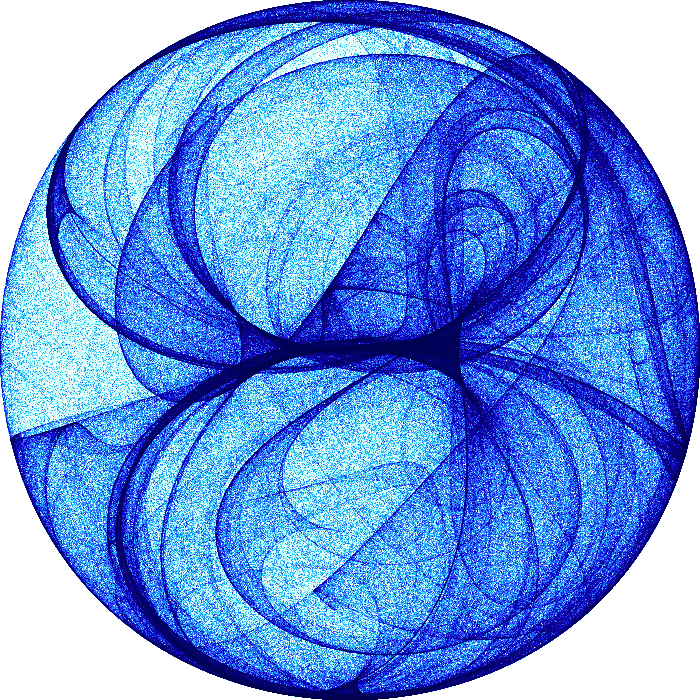

In [13]:
pn.Row(pn.Column(text, pn.Spacer(height=30), ats.equations), pn.Spacer(width=30),
       pn.Column(ats.view, pn.Row(pn.Spacer(width=200),player)), pn.Spacer(width=50),
       pn.Column(pn.Param(ats.param, expand=True, width=220))).servable()

You can replace `.servable()` with `.show()` if you want to launch a standalone dashboard immediately from within the Jupyter notebook, or just run this notebook through Bokeh Server using `panel serve --show attractors_panel.ipynb`. Either way, you should get a browser tab with a dashboard like in the above cell, which you can explore or share.